In [2]:
import splitwavepy as sw
import numpy as np
import math
import matplotlib.pyplot as plt

In [74]:
dat = sw.Data(delta=0.1, noise=0.01, split=(30, 1.3))
x0 = dat.x
y0 = dat.y

The correlation and the variance of the data are connected by the covariance.

The Pearson correlation coefficient $\rho$, is maximised between the *fast* and *slow* components when the data are corrected for splitting.
$\rho(X,Y) = \frac{\operatorname{cov}(X,Y)}{\sigma_{X}\sigma_{Y}}$

The variance.  This is equivalent to the energy.  The energy is maximised on the *polarisation* component and minimised on the *transverse* component when the data are corrected for splitting.
$\operatorname{var}(X) = \operatorname{cov}(X,X)$

The covariance is defined as:
$\operatorname{cov}(X,Y) = \operatorname {E} [(X-\operatorname{E}[X])(Y-\operatorname{E}[Y])]$, or calculated using:
$\operatorname{cov}(X,Y) = \frac{1}{n} \Sigma^{n}_{i=1}(x_i - \mu_x)(y_i - \mu_y)$

A faster (but potentially numerically unstable) way to calculate the covariance is:
$\operatorname{cov}(X,Y) = \operatorname {E} [XY] - \operatorname {E}[X] \operatorname {E}[Y]$

The variance-covariance matrix:
$\Sigma _{ij}=\operatorname {cov} (X_{i},X_{j})=\operatorname {E} [(X_{i}-\mu _{i})(X_{j}-\mu _{j})]=\operatorname {E} [X_{i}X_{j}]-\mu _{i}\mu _{j}$




In [70]:
def rotate(x,y,degrees):
    """row 0 is x-axis and row 1 is y-axis,
       rotates from x to y axis
       e.g. N to E if row 0 is N cmp and row1 is E cmp"""
    ang = math.radians(degrees)
    rot = np.array([[ np.cos(ang), np.sin(ang)],
                    [-np.sin(ang), np.cos(ang)]])
    xy = np.dot(rot, np.vstack((x,y)))
    return xy[0], xy[1]

def rot2(x, y, deg):
    ang = math.radians(deg)
    cang = math.cos(ang)
    sang = math.sin(ang)
    rot = np.array([[ cang, sang],
                    [-sang, cang]])
    xy = np.dot(rot, np.vstack((x,y)))
    return xy[0], xy[1]

def get_c(dx, dy):
    c = np.empty((2, 2))
    c[0][0] = np.sum(dx**2)
    c[0][1] = c[1][0] = np.sum(dx*dy)
    c[1][1] = np.sum(dy**2)
    return c / (np.sqrt(c[0][0]) * np.sqrt(c[1][1]))

def slagchop(x, y, w0, w1, slag):
    d = int(slag/2)
    return x[w0+d: w1+d], y[w0-d: w1-d] 

def running_mean(x, w0, w1, slags):
    d = int(slags[-1]/2)
    x = x[w0-d: w1+d]
    n = w1-w0
    return np.convolve(x, np.ones((n,))/n, mode='valid')

def rotmat(ang):
    sang = math.sin(ang)
    cang = math.cos(ang)
    return np.array([[ cang, sang],
                    [-sang, cang]])

def cov22(x, y):
    c = np.empty((2, 2))
    n = x.size
    exx = np.sum(x*x)
    exy = np.sum(x*y)
    eyy = np.sum(x*y)
    ex = np.sum(x)
    ey = np.sum(y)
    c[0, 0] = exx - ex*ex
    c[0, 1] = c[1, 0] = exy - ex*ey
    c[1, 1] = eyy - ey*ey
    return c / n

# slower
# def running_mean2(x, w0, w1, maxslag):
#     d = int(maxslag/2)
#     x = x[w0-d: w1+d]
#     n = w1-w0
#     cumsum = np.cumsum(np.insert(x, 0, 0))
#     return (cumsum[n:] - cumsum[:-n]) / float(n)


In [68]:
degs = np.linspace(0, 180, 180, endpoint=False)
lags = np.linspace(0, 8, 60)
slags = np.unique(sw.core.core.time2samps(lags, dat.delta, mode='even'))

def gridcov(x, y, w0, w1, degs, slags):
    # prepare a list of data rotated to degs
    rot_data = [ rot2(x0, y0, deg) for deg in degs ]
    # prepare empty covariance arrays
    gridcov = np.empty((degs.size, slags.size, 2, 2))
    c = np.empty((2, 2))
    ii = 0
    # now loop and calculate
    for rot in rot_data:  
        # this is the mean in each window
        meanx = running_mean(rot[0], w0, w1, slags)
        meany = running_mean(rot[1], w0, w1, slags)
        jj = 0
        for slag in slags:
            wx, wy  = slagchop(*rot, w0, w1, slag)
            dx, dy = wx - meanx[slag], wy - meany[slag]
            n = dx.size
            c[0, 0] = np.sum(dx * dx)
            c[1, 0] = c[0, 1] = np.sum(dx * dy)
            c[1, 1] = np.sum(dy * dy)
            c = c / n
#             print(ii,jj,c)
            gridcov[ii, jj, :, :] = c 
            jj += 1
        ii += 1
    return gridcov

# gridcov2 -- using the "trick" that cov(x,y) =  E[xy] - E[x]E[y] 
# this is slower than gridcov
# probably because the calculation of dx and dy is useful for calculating variances quickly.
def gridcov2(x, y, w0, w1, degs, slags):
    # prepare a list of data rotated to degs
    rot_data = [ rot2(x0, y0, deg) for deg in degs ]
    # prepare empty covariance arrays
    gridcov = np.empty((degs.size, slags.size, 2, 2))
    c = np.empty((2, 2))
    ii = 0
    # now loop and calculate
    for rot in rot_data:  
        # this is the mean in each window
        meanx = running_mean(rot[0], w0, w1, slags)
        meany = running_mean(rot[1], w0, w1, slags)
        jj = 0
        for slag in slags:
            wx, wy  = slagchop(*rot, w0, w1, slag)
#             dx, dy = wx - meanx[slag], wy - meany[slag]
            exy = np.mean(wx * wy)
            ex = meanx[slag]
            ey = meany[slag]
            c[0, 0] = np.var(wx)
            c[1, 0] = c[0, 1] = exy - ex * ey
            c[1, 1] = np.var(wy)
            gridcov[ii, jj, :, :] = c 
            jj += 1
        ii += 1
    return gridcov

# gridcov3 -- using numpy.cov function explicitly
# this is even slower than gridcov2.
def gridcov3(x, y, w0, w1, degs, slags):
    # prepare a list of data rotated to degs
    rot_data = [ rot2(x0, y0, deg) for deg in degs ]
    # prepare empty covariance arrays
    gridcov = np.empty((degs.size, slags.size, 2, 2))
    c = np.empty((2, 2))
    ii = 0
    # now loop and calculate
    for rot in rot_data:  
        jj = 0
        for slag in slags:
            wx, wy  = slagchop(*rot, w0, w1, slag)
            gridcov[ii, jj, :, :] = np.cov(wx,wy)
            jj += 1
        ii += 1
    return gridcov

# gridcov4 -- don't precalculate means
# as expected this is slower than gridcov, but faster than others.
# something like this is probably needed if source correction needs to be applied
def gridcov4(x, y, w0, w1, degs, slags):
    # prepare a list of data rotated to degs
    rot_data = [ rot2(x0, y0, deg) for deg in degs ]
    # prepare empty covariance arrays
    gridcov = np.empty((degs.size, slags.size, 2, 2))
    c = np.empty((2, 2))
    ii = 0
    # now loop and calculate
    for rot in rot_data:  
        jj = 0
        for slag in slags:
            wx, wy  = slagchop(*rot, w0, w1, slag)
            mx, my = np.mean(wx), np.mean(wy)
            dx, dy = wx - mx, wy - my
            n = dx.size
            c[0, 0] = np.sum(dx * dx)
            c[1, 0] = c[0, 1] = np.sum(dx * dy)
            c[1, 1] = np.sum(dy * dy)
            c = c / n
            gridcov[ii, jj, :, :] = c 
            jj += 1
        ii += 1
    return gridcov

# gridcov5 -- use numpy.cov in list comprehension
def gridcov5(x, y, w0, w1, degs, slags):
    # prepare a list of data rotated to degs
    rot_data = [ rot2(x0, y0, deg) for deg in degs ]
    # grid search
    gridcov = [ [ np.cov(*slagchop(*rot, w0, w1, slag)) for slag in slags ] for rot in rot_data ]
    return np.asarray(gridcov)



In [75]:
x, y, w0, w1 = dat.x, dat.y, dat._w0(), dat._w1()

In [36]:
%timeit gridcov(x, y, w0, w1, degs, slags)
c = gridcov(x, y, w0, w1, degs, slags)

# fast slow correlation method
stdx = np.sqrt(c[:, :, 0, 0])
stdy = np.sqrt(c[:, :, 1, 1])
rho = c[:, :, 0, 1] / (stdx * stdy)

# silver and chan eigenvalue method
eigvals, eigvecs = np.linalg.eigh(c[:, :])
lam2 = eigvals[:, :, 0]
lam1 = eigvals[:, :, 1]

# # silver and chan transenergy method
# pol = 0
# var = np.empty(c.shape)
# # rotmats = np.asarray([ rotmat(math.radians(pol-deg)) for deg in degs ])
# # var = np.tensordot(c, rotmats, 2)
# for ii in range(degs.size):
#     r = rotmat(math.radians(pol-degs[jj]))
#     for jj in range(slags.size):
#         var[ii,jj,:,:] = np.dot(r, c[ii,jj,:,:])
        
# var1 = var[:,:,0,0]
# var2 = var[:,:,1,1]



10 loops, best of 3: 136 ms per loop


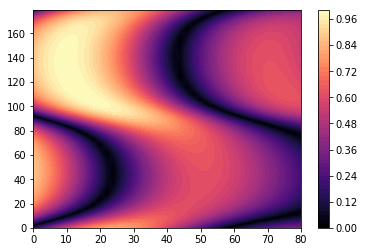

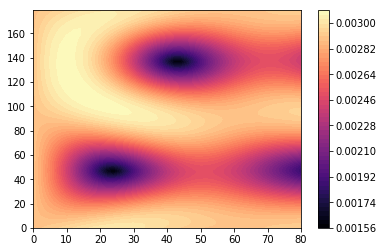

In [11]:
ll, dd = np.meshgrid(slags, degs)
# plot rho
plt.contourf(ll, dd, abs(rho), 50, cmap='magma')
plt.colorbar()
plt.show()
# plot lam1
plt.contourf(ll, dd, lam1, 50, cmap='magma')
plt.colorbar()
plt.show()

1 loop, best of 3: 332 ms per loop


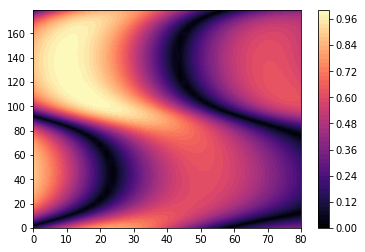

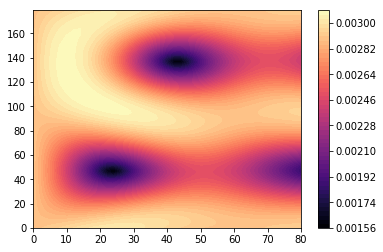

In [23]:
%timeit gridcov2(x, y, w0, w1, degs, slags)

c = gridcov2(x, y, w0, w1, degs, slags)

# fast slow correlation method
stdx = np.sqrt(c[:, :, 0, 0])
stdy = np.sqrt(c[:, :, 1, 1])
rho = c[:, :, 0, 1] / (stdx * stdy)

# silver and chan eigenvalue method
eigvals, eigvecs = np.linalg.eigh(c[:, :])
lam2 = eigvals[:, :, 0]
lam1 = eigvals[:, :, 1]

# plots
ll, dd = np.meshgrid(slags, degs)
# plot rho
plt.contourf(ll, dd, abs(rho), 50, cmap='magma')
plt.colorbar()
plt.show()
# plot lam1
plt.contourf(ll, dd, lam1, 50, cmap='magma')
plt.colorbar()
plt.show()

1 loop, best of 3: 350 ms per loop


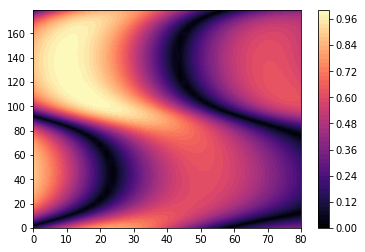

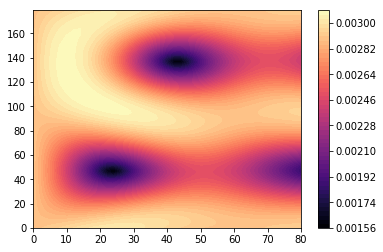

In [26]:
%timeit gridcov3(x, y, w0, w1, degs, slags)

c = gridcov2(x, y, w0, w1, degs, slags)

# fast slow correlation method
stdx = np.sqrt(c[:, :, 0, 0])
stdy = np.sqrt(c[:, :, 1, 1])
rho = c[:, :, 0, 1] / (stdx * stdy)

# silver and chan eigenvalue method
eigvals, eigvecs = np.linalg.eigh(c[:, :])
lam2 = eigvals[:, :, 0]
lam1 = eigvals[:, :, 1]

# plots
ll, dd = np.meshgrid(slags, degs)
# plot rho
plt.contourf(ll, dd, abs(rho), 50, cmap='magma')
plt.colorbar()
plt.show()
# plot lam1
plt.contourf(ll, dd, lam1, 50, cmap='magma')
plt.colorbar()
plt.show()

1 loop, best of 3: 219 ms per loop


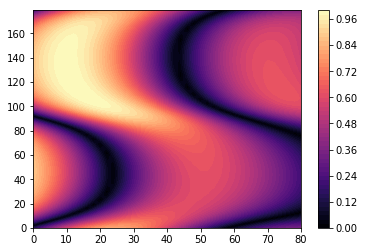

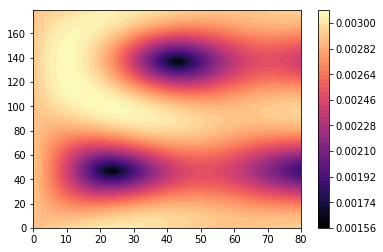

In [59]:
%timeit gridcov4(x, y, w0, w1, degs, slags)

c = gridcov4(x, y, w0, w1, degs, slags)

# fast slow correlation method
stdx = np.sqrt(c[:, :, 0, 0])
stdy = np.sqrt(c[:, :, 1, 1])
rho = c[:, :, 0, 1] / (stdx * stdy)

# silver and chan eigenvalue method
eigvals, eigvecs = np.linalg.eigh(c[:, :])
lam2 = eigvals[:, :, 0]
lam1 = eigvals[:, :, 1]

# plots
ll, dd = np.meshgrid(slags, degs)
# plot rho
plt.contourf(ll, dd, abs(rho), 50, cmap='magma')
plt.colorbar()
plt.show()
# plot lam1
plt.contourf(ll, dd, lam1, 50, cmap='magma')
plt.colorbar()
plt.show()

In [19]:
%timeit gridcov2(x, y, w0, w1, degs, slags)

1 loop, best of 3: 319 ms per loop


In [18]:
dat._w1()

659

In [28]:
np.convolve?

In [156]:
eigvals, eigvecs = np.linalg.eigh(c[:,:])

In [163]:
eigvals[:,:,0]

array([[ 0.00017179,  0.00016396,  0.00014071, ...,  0.00015749,
         0.00015389,  0.00015304],
       [ 0.00017179,  0.0001686 ,  0.00015333, ...,  0.00015984,
         0.00015618,  0.00015501],
       [ 0.00017179,  0.00017333,  0.00016662, ...,  0.00016693,
         0.00016358,  0.00016227],
       ..., 
       [ 0.00017179,  0.00015074,  0.00010718, ...,  0.00017784,
         0.00017654,  0.00017781],
       [ 0.00017179,  0.00015501,  0.00011762, ...,  0.00016665,
         0.00016423,  0.0001646 ],
       [ 0.00017179,  0.00015943,  0.0001288 , ...,  0.00015981,
         0.00015661,  0.00015629]])

In [205]:
degs = np.linspace(0, 180, 90, endpoint=False)
lags = np.linspace(0, 8, 30)
slags = np.unique(sw.core.core.time2samps(lags, dat.delta, mode='even'))
%timeit gridcov(x, y, w0, w1, degs, slags)

66.6 ms ± 487 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


1 loop, best of 3: 369 ms per loop


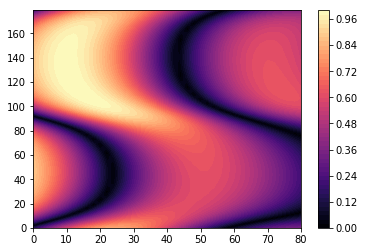

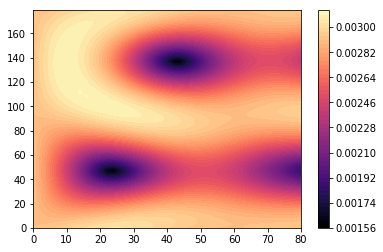

In [69]:
%timeit gridcov5(x, y, w0, w1, degs, slags)
c = gridcov5(x, y, w0, w1, degs, slags)

# fast slow correlation method
stdx = np.sqrt(c[:, :, 0, 0])
stdy = np.sqrt(c[:, :, 1, 1])
rho = c[:, :, 0, 1] / (stdx * stdy)

# silver and chan eigenvalue method
eigvals, eigvecs = np.linalg.eigh(c[:, :])
lam2 = eigvals[:, :, 0]
lam1 = eigvals[:, :, 1]

# plots
ll, dd = np.meshgrid(slags, degs)
# plot rho
plt.contourf(ll, dd, abs(rho), 50, cmap='magma')
plt.colorbar()
plt.show()
# plot lam1
plt.contourf(ll, dd, lam1, 50, cmap='magma')
plt.colorbar()
plt.show()

In [80]:
%timeit cov22(x, y)

The slowest run took 20.35 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 19 µs per loop


In [81]:
%timeit np.cov(x, y)

10000 loops, best of 3: 46.7 µs per loop


In [82]:
cov22(x, y)

array([[  9.57185303e-04,   3.46678006e-05],
       [  3.46678006e-05,  -1.08243312e-04]])

In [83]:
np.cov(x, y)

array([[  9.58329450e-04,   3.97970702e-05],
       [  3.97970702e-05,   7.15653068e-05]])

In [92]:
x = np.random.random((10, 2))
y = np.random.random((10, 2))

In [95]:
c0 = np.cov(x, y)

In [101]:
c0

array([[  1.04623997e-01,   1.58875520e-02,  -8.13552811e-02,
          1.11985105e-01,   3.25808817e-02,  -6.91044696e-02,
          6.96973698e-02,  -8.79853645e-02,   8.94860794e-02,
         -1.18825081e-01,   1.41049999e-01,   1.77150293e-01,
         -7.88913845e-02,   9.43780927e-02,  -1.48418879e-01,
          1.78218915e-01,  -1.94938722e-01,   3.75636891e-03,
          5.83478138e-02,  -1.03409204e-01],
       [  1.58875520e-02,   2.41258522e-03,  -1.23541090e-02,
          1.70053642e-02,   4.94753085e-03,  -1.04937766e-02,
          1.05838108e-02,  -1.33609124e-02,   1.35888016e-02,
         -1.80440407e-02,   2.14189791e-02,   2.69009461e-02,
         -1.19799569e-02,   1.43316725e-02,  -2.25379715e-02,
          2.70632204e-02,  -2.96021867e-02,   5.70418911e-04,
          8.86033752e-03,  -1.57030811e-02],
       [ -8.13552811e-02,  -1.23541090e-02,   6.32616030e-02,
         -8.70792548e-02,  -2.53347881e-02,   5.37354117e-02,
         -5.41964490e-02,   6.84171344e-02

In [100]:
np.cov(x[:,0], y[:,0])

array([[ 0.07507137, -0.00753719],
       [-0.00753719,  0.08005866]])